In [1]:
import numpy as np
import pandas as pd
from scipy import signal
def volatility_measure(arr):
    factor = np.arange(1, arr.shape[0]+1)
    arr = np.concatenate([arr[0:1], arr], axis = 0)
    return np.cumsum(np.abs(arr[1:] - arr[:-1]))/factor

In [2]:
def volatility_measure(arr, k):
    
    pad = np.ones(shape = (k, ))*float(np.mean(arr[:k]))
    arr = np.concatenate([pad, arr], axis = 0)
    res = list()
    for i in range(k, arr.shape[0]):
        temp = arr[i-k:i]
        res += [float(np.sum(np.abs(temp[1:] - temp[:-1])))]
    return np.array(res)

In [3]:
def baseline(data, size = 50):
    def pelt(data, penalty):
        def calculate_cost(data, s, t):
            segment = data[s:t+1]
            mean_segment = np.mean(segment)
            cost = np.sum((segment - mean_segment) ** 2)
            return cost
        n = len(data)
        F = np.zeros(n+1)  # 累計成本
        F.fill(np.inf)
        F[0] = 0
        
        # 用於存儲變點的位置
        cps = {0: []}
        
        for t in range(1, n+1):
            for s in range(t):
                cost = calculate_cost(data, s, t-1)
                if F[s] + cost + penalty < F[t]:
                    F[t] = F[s] + cost + penalty
                    cps[t] = cps[s] + [t]
        return cps[n], F[n]
    temp = signal.resample(data, len(data)//size)
    I = list(np.array(pelt(temp, 2*np.log(len(temp)))[0])*size)
    I = [0] + I + [len(data)]
    arr = list()
    for i in range(1, len(I)):
        idxes = np.arange(I[i-1], I[i])
        if idxes.shape[0] == 0:
            continue
        arr += list(np.ones(shape = (idxes.shape[0], ))*float(np.mean(data[idxes])))
    return np.array(arr), I

In [4]:
data = []
for i in range(1, 10+1):
    sample_std = np.random.choice([10, 30, 50, 70], size = (1, ))
    sample_mean = np.random.choice([0, -50, 50, -100, 100], size = (1, ))
    data += list(np.random.normal(sample_mean, sample_std, size = (100, )))
data = np.array(data)

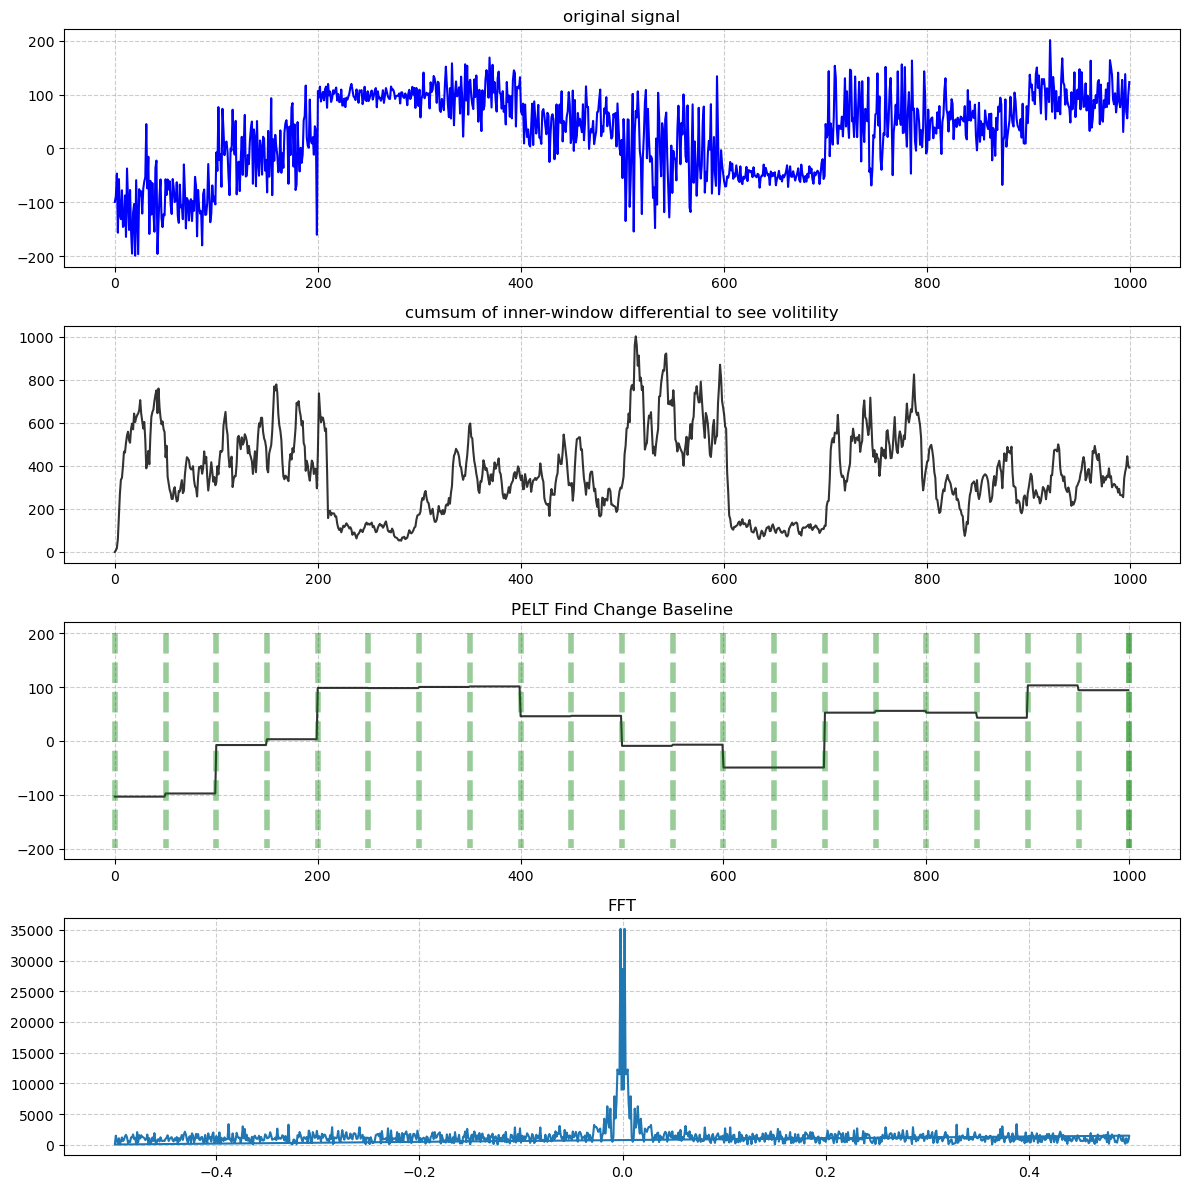

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 1, figsize = (12, 12))
ax[0].plot(data, color = "blue")
ax[0].grid(color = "gray", linestyle = "--", alpha = .4)
ax[0].set_title("original signal")

arr1 = volatility_measure(data, 10)
ax[1].plot(arr1, color = "black", alpha = .8)
ax[1].grid(color = "gray", linestyle = "--", alpha = .4)
ax[1].set_title("cumsum of inner-window differential to see volitility")

arr2, I = baseline(data)
ax[2].plot(arr2, color = "black", alpha = .8)
for i in I:
    ax[2].vlines(i, np.max(data), np.min(data), color = "green", linewidth = 4, linestyle = "--", alpha = .4)
ax[2].grid(color = "gray", linestyle = "--", alpha = .4)
ax[2].set_title("PELT Find Change Baseline")

arr3 = np.abs(np.fft.fft(data))
ax[3].plot(np.fft.fftfreq(data.shape[0], 1), arr3)
ax[3].grid(color = "gray", linestyle = "--", alpha = .4)
ax[3].set_title("FFT")
fig.tight_layout()

In [7]:
def generate_mcm(data, window_sizes, stride):
    time_length, num_features = data.shape
    num_channels = len(window_sizes)
    num_windows = time_length//stride + 1
    
    mcm = np.zeros((num_windows, num_features, num_features, num_channels))
    
    for w_idx, window_size in enumerate(window_sizes):
        for t in range(0, time_length - window_size - 1, stride):
            t_idx = t // stride
            window_data = data[t:t + window_size]
            corr_matrix = np.corrcoef(window_data, rowvar=False)
            mcm[t_idx, :, :, w_idx] = corr_matrix
    
    return mcm
X = np.concatenate([data.reshape(-1, 1), arr1.reshape(-1, 1), arr2.reshape(-1, 1), arr3.reshape(-1, 1)], axis = 1)
print(X.shape)
window_sizes = [5, 10, 15, 20, 25]
stride = 30

# 生成 MCM
mcm = generate_mcm(X, window_sizes, stride)

# 檢查 MCM 的形狀
print("MCM shape:", mcm.shape)  # 預期形狀為 (num_windows, num_features, num_features, num_channels)

(1000, 4)
MCM shape: (34, 4, 4, 5)


In [8]:
cut_arr = list()
win_size = 20
for i in range(win_size, len(data)):
    cut_arr += [list(data[i-win_size:i])]

In [9]:
from sklearn.decomposition import PCA
fft_cut_arr = [np.abs(np.fft.fft(temp))for temp in cut_arr]
pca = PCA(n_components=2)
pca_transformed_data = pca.fit_transform(fft_cut_arr)

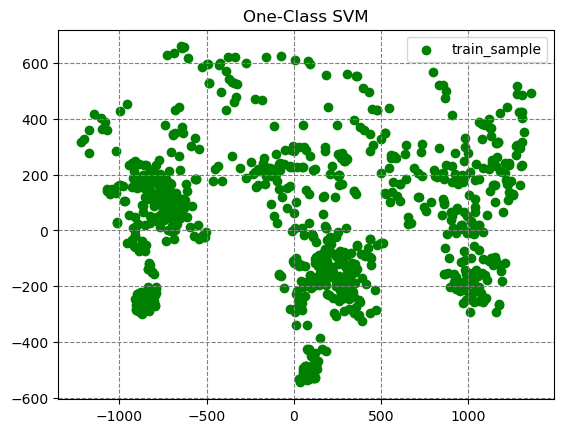

In [10]:
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt

X_train = pca_transformed_data

# 訓練 One-Class SVM 模型
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)


# 預測樣本的異常情況
y_pred_train = clf.predict(X_train)
n_error_train = y_pred_train[y_pred_train == -1].size

# 繪製結果
plt.scatter(X_train[:, 0], X_train[:, 1], color='green', label='train_sample')
xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='blue')
plt.title("One-Class SVM")
plt.legend()
plt.grid(linestyle = "--", color = "gray")
plt.show()